## 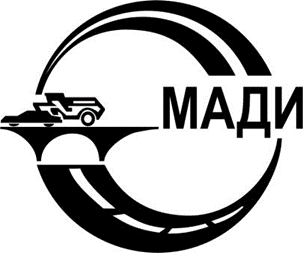

---


**МОСКОВСКИЙ АВТОМОБИЛЬНО-ДОРОЖНЫЙ ГОСУДАРСТВЕННЫЙ
ТЕХНИЧЕСКИЙ УНИВЕРСИТЕТ (МАДИ)**

Кафедра "Высшая математика"

**Лабораторная работа №2**

По дисциплине КОМПЬЮТЕРНАЯ ГРАФИКА

на тему:

"Форматы данных - изображения и видео. Размещение детекторов."

**Выполнил:**

Серов Павел Геннадьевич

Группа 3бПМ

Вариант 14

**Преподаватель:**

Кутейников И.А


**1. Цель**

Изучить библиотеки для обработки фото и видеоизображений.

**2. Исходные данные**

Видеопоток с камеры с веб-камеры:
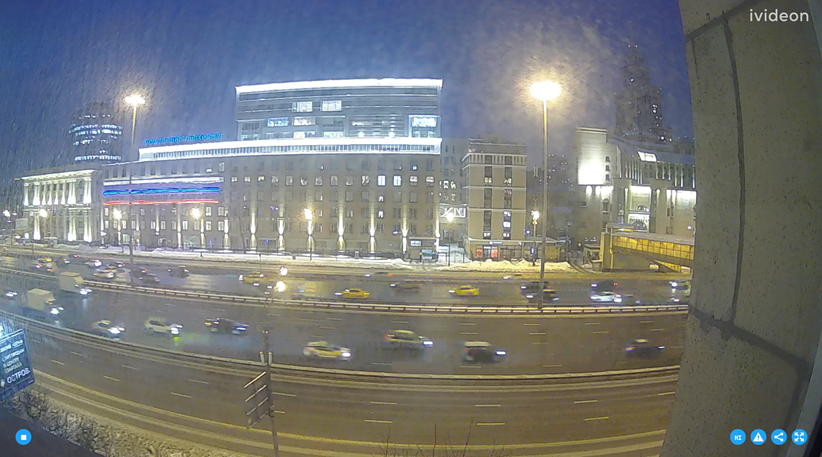

**3. Задача**



1.   Получить видеопоток; 
2.   Разбить видеопоток на кадры;
3.	Конвертировать кадры в градацию серого;
4.	Выставить детекторы, количество детекторов не ограниченно;
5.	Вычислить значение среднего цвета каждого кадра в выбранной области для каждого детектора;
6.	Сравнить значение средних цветов между собой и подсчитать количество автомобилей для каждого детектора;
7.	Построить график по среднему цвету для каждого детектора;
8.	Построить бинаризованный график для каждого детектора;
9.	Построить график изменения среднего цвета по времени для каждого детектора;
10.	Вычислить интенсивность потока (для каждого детектора);




**4. Ход решения**

Импортируем библиотеки

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Создадим класс детекторов

In [2]:
class Detector:
 
    def __init__(self, x, y):
        self.detX = x
        self.detY = y
        self.avgColour = []
        self.detections = []
 
    def addAVGColourSum(self, value):
        self.avgColour.append(value)
 
 
drawing = False
mouseX, mouseY = -1, -1
size = 20
 
number_of_lanes = 3
detectors_per_lane = 2
 
lanes = []
detectors = [] 

Создадим фукнцию для фильтра дескритизации полученных данных с детекторов

In [3]:
def detectorsDiscretizationFilter(detectors, frameCounter):
    for i in range(0, len(detectors)):
        for j in range(0, frameCounter - 1):
            frames_unite = 10
            frames_count = 0
            for k in range(1, frames_unite):
                if (detectors[i].detections[j] == 1 and ((j + k) < (frameCounter - k - 1)) and (
                        detectors[i].detections[j + k] == 1)):
                    frames_count = frames_count + 1
                for l in range(j, j + frames_count):
                    detectors[i].detections[l] = 1
 
    for i in range(0, len(detectors)):
        for j in range(0, frameCounter - 2):
            neighboursSum = detectors[i].detections[j - 1] + detectors[i].detections[j + 1]
            if detectors[i].detections[j] == 1 and neighboursSum == 0:
                detectors[i].detections[j] = 0

Создадим фукнцию для дискретезации полученных данных

In [4]:
def detectorsDiscretization(detectors, frameCounter):
    for detector in detectors:
        detector.detections = [0] * frameCounter
 
    for i in range(0, len(detectors)):
        for j in range(0, frameCounter - 1):
            test = abs((detectors[i].avgColour[j] - detectors[i].avgColour[j + 1]) / detectors[i].avgColour[j]) * 100
            if test > 1.5:
                detectors[i].detections[j + 1] = 1

Функция получения среднего цвета

In [5]:
def getAVGcolourSum(gray, detectors):
    cv.namedWindow('detector', cv.WINDOW_NORMAL)
    for detector in detectors:
        detectorZone = gray[int((detector.detY - (size / 2))):int((detector.detY + (size / 2))),
                       int((detector.detX - (size / 2))):int((detector.detX + (size / 2)))]
        avg_color_per_row = np.average(detectorZone, axis=0)
        avg_color = np.average(avg_color_per_row, axis=0)
        # detector.avgColour.append(avg_color)
        detector.addAVGColourSum(avg_color)
        print(avg_color)
        cv.imshow('detector', detectorZone)

Функция для отрисовки детекторов

In [6]:
def draw_detector(x, y, lane_number):
    colours = [[0, 0, 255], [0, 255, 0], [255, 0, 0], [0, 0, 127], [0, 127, 0], [127, 0, 0]]
    cv.rectangle(frame, (int(x - (size / 2)), int(y - (size / 2))),
                 (int(x + (size / 2)), int(y + (size / 2))), colours[lane_number], 2)

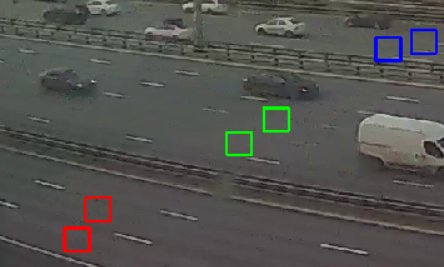

Функция для установки детекторов

In [7]:
def set_detector(event, x, y, flags, param, count_of_lanes=0):
    global mouseX, mouseY, drawing
 
    if event == cv.EVENT_LBUTTONDOWN:
        if len(lanes) != 0 and len(lanes) * len(lanes[0]) == number_of_lanes * detectors_per_lane:
            print("Max number of detectors reached")
        else:
            mouseX, mouseY = x, y
            draw_detector(mouseX, mouseY, len(lanes))
            cv.imshow('Frame', frame)
            print(str(mouseX) + " " + str(mouseY))
            if len(detectors) < detectors_per_lane:
                detectors.append(Detector(mouseX, mouseY))
            if len(detectors) == detectors_per_lane:
                lanes.append(detectors.copy())
                detectors.clear()

Откроем видео и обработаем его покадрово

проверим время работы алгоритма

In [9]:
from datetime import datetime
t1 = datetime.now()
# image_path = r'E:\PyProjects\pythonProject\Brain.jpg'
# directory = r'E:\PyProjects\pythonProject\new folder'
frameCounter = 0
 
cap = cv.VideoCapture('C:/Users/pasha/Downloads/07.30.00-07.35.00[R][0@0][0].mp4')
 
if not cap.isOpened():
    print("Error opening file")
 
cv.namedWindow('Frame', cv.WINDOW_NORMAL)
cv.setMouseCallback('Frame', set_detector)
 
cv.resizeWindow('Frame', 1920, 1080)
# os.chdir(directory)
 
# cap.set(1, 0)
ret, frame = cap.read()
 
cv.imshow('Frame', frame)
cv.waitKey(0)
cv.namedWindow('Frame', cv.WINDOW_NORMAL)
cv.resizeWindow('Frame', 800, 600)


# Обработка видео до последнего кадра
while (cap.isOpened()):
    # plt.axis([0, frameCounter, 0, 100])
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    # Переводим в градации серого
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # Если считался очередной кадр
    if ret == True:
        # Выводим номер кадра в верхнем левом углу
        cv.putText(frame, "Frame " + str(frameCounter), (50, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2,
                   cv.LINE_AA)
        # Отрисовка детекторов
        colour_counter = 0
        for lane in lanes:
            for detector in lane:
                draw_detector(detector.detX, detector.detY, colour_counter)
            colour_counter += 1
            getAVGcolourSum(gray, lane)
        cv.imshow('Frame', frame)
        # if frameCounter % 10 == 0:
        # cv.imwrite("Frame_" + str(frameCounter) + ".png",frame)
        frameCounter += 1
        if cv.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()
cv.destroyAllWindows()
# plt.axes[(1 , 1000) , (1,255)]
 
# print(detectors[0].avgColour[0])
t2 = datetime.now()

525 845
545 804
596 706
627 665
683 589
697 582
77.0125
77.53000000000002
86.58500000000001
87.53750000000001
90.75750000000002
89.5225
76.8175
78.00500000000001
84.7025
85.98
90.93750000000001
90.22000000000001
76.9225
78.00500000000001
84.995
86.12
90.9625
90.20250000000001
76.9325
78.00500000000001
84.63499999999999
85.6525
90.725
90.25000000000003
76.9325
78.00500000000001
84.8925
85.5325
90.8775
90.39250000000001
77.2825
78.17
86.60249999999999
84.74750000000002
92.64999999999999
92.48249999999999
77.2825
78.16999999999999
86.60249999999999
85.1375
92.86500000000001
97.87499999999999
77.2825
78.23500000000001
86.60249999999999
85.4525
93.9075
97.78
77.5125
78.285
86.71
86.3775
94.0425
98.13999999999999
77.5125
78.285
86.71
86.4
88.74500000000002
107.61750000000002
77.52
78.30499999999999
86.71
86.56249999999999
87.885
104.8975
77.49249999999999
78.2825
86.7
86.48
92.705
94.92500000000001
77.675
78.41749999999999
86.74
86.56250000000001
91.32500000000002
90.80499999999999
77.567500

77.62749999999998
82.98499999999999
87.985
89.66999999999999
81.16000000000001
77.315
77.62749999999998
83.02
87.99
88.56
74.78999999999999
77.31
77.65249999999999
83.6875
87.9525
85.38250000000001
73.64000000000001
77.39500000000001
77.7775
83.75000000000001
87.9525
82.965
73.16499999999999
77.39500000000001
77.75250000000001
83.75250000000001
87.9725
81.49250000000002
72.7425
77.405
77.78
83.82750000000001
87.9725
83.50500000000002
72.98249999999999
77.44500000000002
77.78
84.22
87.96000000000001
83.6
76.46249999999999
77.45000000000002
77.7875
84.25
87.96000000000001
84.64
81.985
77.44000000000001
77.75500000000001
84.19249999999998
87.96000000000001
86.6175
86.525
77.44000000000001
77.75500000000001
84.2025
87.96000000000001
88.82000000000001
87.2675
77.4
77.75500000000001
84.41
87.96000000000001
89.9
87.61000000000001
77.44000000000001
77.75500000000001
84.35249999999999
87.96000000000001
89.82500000000002
87.41
77.4
77.75500000000001
84.42750000000001
87.96000000000001
90.1225
88

77.8225
84.625
86.85
90.54
71.2825
77.7
77.8225
83.35
87.9675
84.3475
65.47749999999999
77.7
77.8225
82.845
109.715
79.465
64.53750000000001
77.7
77.8225
81.5275
89.44999999999999
77.955
65.30749999999999
77.655
77.8225
81.6525
79.265
77.41999999999999
65.73749999999998
77.64500000000001
77.905
81.485
104.4325
78.20750000000001
72.02749999999999
77.64500000000001
77.905
81.265
120.03249999999998
78.1975
76.47250000000001
77.64500000000001
77.905
81.435
120.45499999999997
74.115
78.1125
77.64500000000001
77.905
82.12250000000002
120.505
68.6725
76.6175
77.64500000000001
77.905
83.76249999999999
120.1125
67.72
74.55000000000001
77.69
77.905
84.6675
120.30250000000001
66.11
73.005
77.68
77.905
84.5375
104.8
65.1125
74.61999999999998
77.68
77.905
84.6675
86.87499999999999
64.88250000000001
80.83250000000001
77.68
77.905
84.66
86.87750000000001
74.35000000000001
88.03750000000001
77.68
77.905
84.73500000000001
87.06000000000002
83.27499999999999
87.425
77.68
77.905
84.73500000000001
87.015


76.73749999999998
85.8275
88.1075
93.60749999999999
90.82
78.2875
76.7175
85.75999999999999
88.0725
93.6525
90.83500000000001
78.07000000000001
76.7175
85.32750000000001
88.0625
93.6525
90.76500000000001
78.0875
76.81500000000001
86.655
88.0675
93.655
90.84000000000002
78.0875
76.71000000000001
87.02750000000002
85.7975
93.70250000000001
90.8525
78.0875
76.71000000000001
86.905
74.3375
93.8225
90.745
78.0875
76.71000000000001
86.7975
69.4975
93.795
94.03000000000002
78.0875
76.71000000000001
86.92999999999999
67.7825
94.02
96.59999999999998
78.0875
76.71000000000001
86.57999999999998
67.84250000000002
92.11749999999999
100.30499999999999
78.0875
76.71000000000001
86.3825
65.24
86.77749999999999
110.59
78.0875
76.71000000000001
86.375
70.2175
89.86
121.93500000000002
78.0875
76.71000000000001
86.4775
81.66999999999999
98.22999999999999
117.40749999999998
78.0875
76.71000000000001
86.4775
85.77250000000001
99.77999999999999
114.9875
78.0875
76.71000000000001
86.4775
85.7475
95.1525
119.7

77.565
86.9
87.1275
98.39
83.6625
77.70250000000001
77.565
86.87249999999999
87.1225
99.17
87.965
77.70250000000001
77.595
86.87999999999998
87.1275
104.9025
91.38500000000002
77.67
77.5825
86.87249999999999
87.1025
115.025
87.91000000000001
77.55749999999999
77.62
86.88499999999999
87.125
102.61500000000001
82.49249999999998
77.55749999999999
77.58250000000001
86.87249999999999
87.1225
85.815
88.36
77.6
77.6675
86.9525
87.18250000000002
89.3025
88.45250000000001
77.575
77.62500000000003
86.93249999999999
87.18
90.48499999999999
88.49249999999999
77.60499999999999
77.57000000000001
86.95
87.28000000000002
90.945
88.9675
77.52249999999998
77.5575
86.91
87.22500000000001
92.37750000000001
90.07000000000002
77.54
77.57750000000001
86.92
87.22500000000001
92.42499999999998
90.07500000000002
77.5
77.55500000000002
86.92
87.22500000000001
92.42499999999998
90.4625
77.54249999999999
77.55500000000002
86.92
87.2675
92.54249999999999
90.63999999999999
77.54249999999999
77.55500000000002
86.92
8

77.03
86.21
87.57000000000002
82.5075
93.0
77.5375
77.03
86.25500000000001
116.07750000000001
83.87500000000001
92.1975
77.72
76.93750000000001
86.1125
116.11749999999999
86.3525
87.50499999999998
77.81000000000002
76.93750000000001
86.18500000000002
91.57749999999999
86.97500000000001
87.105
78.26750000000001
76.93750000000001
86.33000000000001
98.29
89.3175
87.2875
78.35
76.93750000000001
86.2925
106.8
89.8725
87.795
78.24749999999997
76.93750000000001
85.8475
113.13999999999999
90.115
90.85999999999999
78.28
77.03
85.86749999999999
89.7625
90.17999999999998
97.205
78.28
77.03
85.85
87.03
93.065
98.16749999999999
78.2975
77.035
85.8525
87.05750000000002
93.5725
98.74
78.25500000000001
76.94250000000001
85.975
87.045
91.97
101.42999999999999
78.26
77.035
86.00500000000001
87.23249999999999
88.9
110.085
78.23
76.9575
86.00500000000001
86.975
87.52499999999999
107.37249999999999
78.32
77.04999999999998
86.00500000000001
86.92249999999999
91.22999999999999
98.8375
78.33000000000001
77.04

76.85
86.58
86.905
90.39
86.9075
77.80499999999999
76.8825
86.58
86.985
90.9425
87.69500000000001
77.7975
76.86500000000001
86.58
86.985
89.9125
87.68250000000002
77.95750000000001
77.0275
86.64750000000001
87.01750000000001
86.10000000000001
88.155
77.95000000000002
77.0275
86.645
86.895
81.8925
89.08250000000001
77.95500000000001
77.0275
86.68499999999999
86.13500000000002
79.78999999999999
93.115
77.9425
76.975
86.6125
86.1025
80.5325
99.1375
78.02
77.04499999999999
86.5775
86.03999999999999
90.09
104.67749999999998
77.9375
76.94999999999999
86.7025
86.10499999999999
90.70750000000001
114.97749999999999
78.025
76.935
86.71000000000001
86.06750000000001
91.325
108.665
78.005
76.9625
86.71000000000001
85.81999999999998
94.06500000000001
95.24000000000001
78.005
76.9425
86.7
85.8125
87.1925
77.91749999999999
78.005
76.98249999999999
86.7775
86.0475
77.845
69.14500000000001
78.005
76.93249999999999
86.775
86.18249999999999
71.63499999999999
65.355
78.005
76.97499999999998
86.72999999999

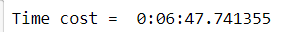

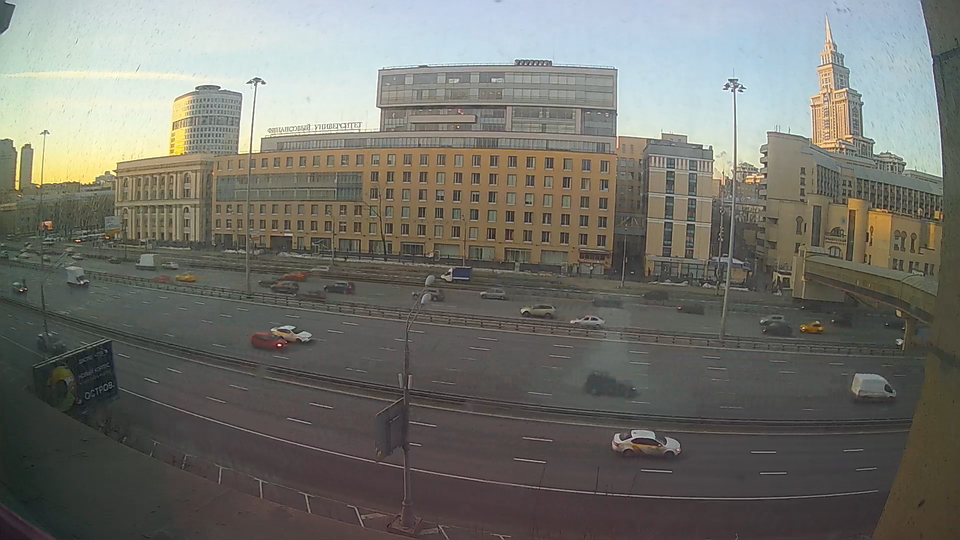

Заполняем csv файл координатами детекторов

In [10]:
data = dict()
lane_counter = 1
for lane in lanes:
    detectorNumber = 1
    for detector in lane:
        new_dict = {"lane" + str(lane_counter) + " det" + str(detectorNumber) + " X": [detector.detX], "lane" + str(lane_counter) + " det" + str(detectorNumber) + " Y": [detector.detY]}
        data.update(new_dict)
        detectorNumber += 1
    lane_counter += 1
df = pd.DataFrame(data)
df.to_csv(r'Coordinates.csv', sep=';', index=False)

Заполняем csv файл средними цветами с детекторов

In [11]:
data = dict()
lane_counter = 1
for lane in lanes:
    detectorNumber = 1
    for detector in lane:
        new_dict = {"lane" + str(lane_counter) + " det" + str(detectorNumber): detector.avgColour}
        data.update(new_dict)
        detectorNumber += 1
    lane_counter += 1
df = pd.DataFrame(data)
df.to_csv(r'AvgColours.csv', sep=';', index=False)
 
for lane in lanes:
    detectorsDiscretization(lane, frameCounter)

Заполняем csv файл дискретными значениями с детекторов

In [12]:
data = dict()
lane_counter = 1
for lane in lanes:
    detectorNumber = 1
    for detector in lane:
        new_dict = {"lane" + str(lane_counter) + " det" + str(detectorNumber): detector.detections}
        data.update(new_dict)
        detectorNumber += 1
    lane_counter += 1
df = pd.DataFrame(data)
df.to_csv(r'RawDetections.csv', sep=';', index=False)
 
for lane in lanes:
    detectorsDiscretizationFilter(lane, frameCounter)

Заполняем csv файл дискретными отфильтрованными значениями с детекторов

In [13]:
data = dict()
lane_counter = 1
for lane in lanes:
    detectorNumber = 1
    for detector in lane:
        new_dict = {"lane" + str(lane_counter) + " det" + str(detectorNumber): detector.detections}
        data.update(new_dict)
        detectorNumber += 1
    lane_counter += 1
df = pd.DataFrame(data)
df.to_csv(r'FilteredDetections.csv', sep=';', index=False)

Построим графики для среднего цвета по кадрам

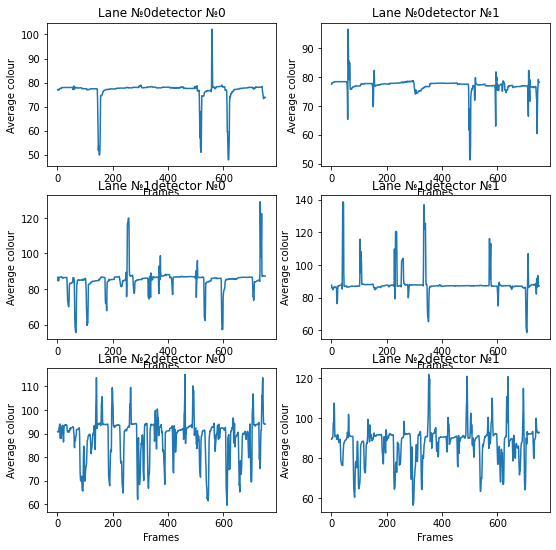

In [14]:
x = []
for i in range(1, frameCounter + 1):
    x.append(i)

position = 1
 
fig, axs = plt.subplots(number_of_lanes, detectors_per_lane, figsize=(9, 9))
i = 0
for lane in lanes:
    j = 0
    for detector in lane:
        axs[i, j].plot(x, detector.avgColour)
        axs[i, j].set_title("Lane №" + str(i) + "detector №" + str(j))
        j += 1
    i += 1
for ax in axs.flat:
    ax.set(xlabel="Frames", ylabel="Average colour")
plt.show()

Построим дискритизированные графики количества автомобилей

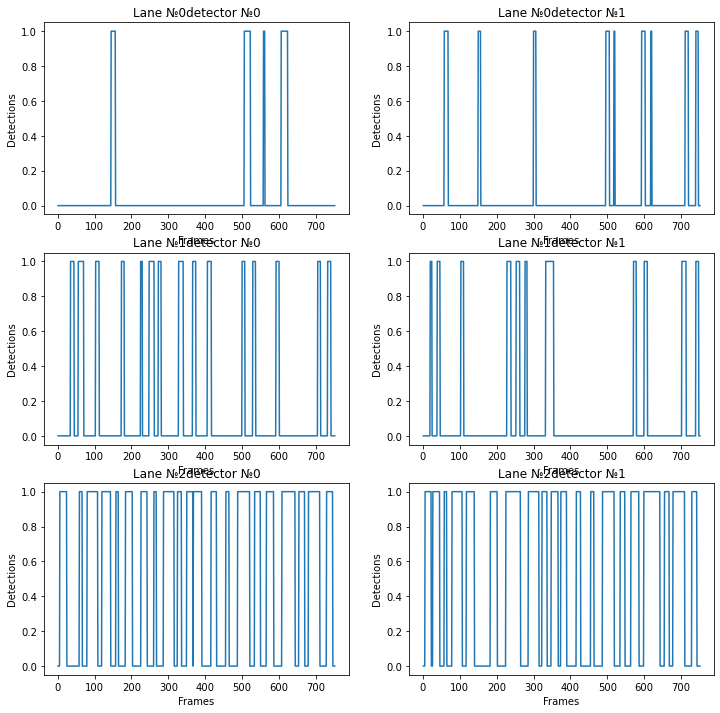

In [15]:
fig, axs = plt.subplots(number_of_lanes, detectors_per_lane, figsize=(12, 12))
i = 0
for lane in lanes:
    j = 0
    for detector in lane:
        axs[i, j].plot(x, detector.detections)
        axs[i, j].set_title("Lane №" + str(i) + "detector №" + str(j))
        j += 1
    i += 1
for ax in axs.flat:
    ax.set(xlabel="Frames", ylabel="Detections")
plt.show()

Функция для вычисления интенсивности потока

In [18]:
frame_rate = 25
lane_density_per_sec = []
lanes_density_per_sec = []

def density_to_sec(density_lanes):
    for lane in density_lanes:
        frame_counter = 0
        second = 1
        while frame_counter <= len(lane):
            frame_sum = 0
            for i in range(frame_rate * (second - 1), frame_rate * second):
                if i < len(lane):
                    frame_sum += lane[i]
                frame_counter += 1
            lane_density_per_sec.append(frame_sum/frame_rate)
            second += 1
        lanes_density_per_sec.append(lane_density_per_sec.copy())
        lane_density_per_sec.clear()

number_of_lanes = 3  # количество полос
detectors_per_lane = 2  # количество детекторов на полосу

Построим график интенсивности

0


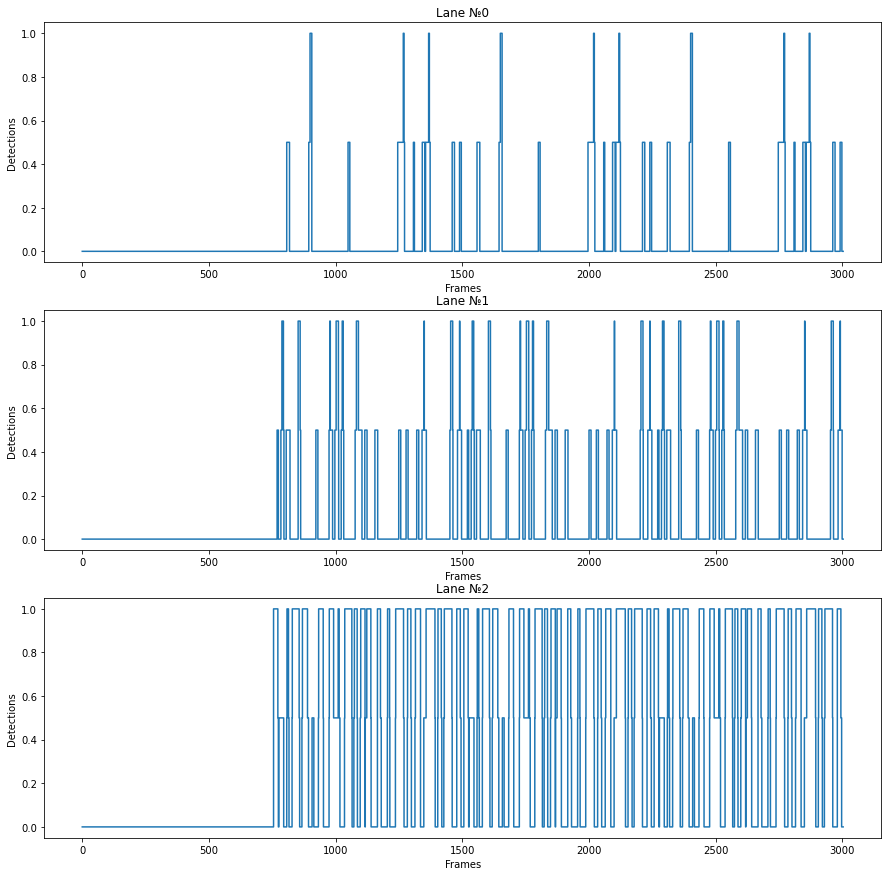

In [19]:
df = pd.read_csv('FilteredDetections.csv')
 
for i in range(len(df)):
    single_line_values = df.values[i][0].split(';')
    m = 0
    for j in range(len(lanes)):
        for k in range(len(lanes[j])):
            lanes[j][k].detections.append(single_line_values[m])
            m += 1

print(single_line_values[5][0])
# плотность на полосу
density_per_lane = []
# плотность по полосам
density_lanes = []
 
detections_counter = 0
for i in range(len(lanes)):
    for k in range(len(lanes[i][0].detections)):
        for j in range(len(lanes[i])):
            if lanes[i][j].detections[k] == '1':
                detections_counter += 1.0
        density_per_lane.append(detections_counter / len(lanes[i]))
        detections_counter = 0
    density_lanes.append(density_per_lane.copy())
    density_per_lane.clear()

x = []
for i in range(0, len(lanes[0][0].detections)):
    x.append(i)


density_to_sec(density_lanes)

fig, axs = plt.subplots(number_of_lanes, figsize=(15, 15))
i = 0
for lane in density_lanes:
    j = 0
    axs[i].step(x, lane)
    axs[i].set_title("Lane №" + str(i))
    i += 1
for ax in axs.flat:
    ax.set(xlabel="Frames", ylabel="Detections")
plt.show()

Подсчитаем количество автомобилей на каждом детекторе

In [63]:
lane_counter = 1
for lane in lanes:
    detectorNumber = 1
    for detector in lane:
        count = 0
        for i in range(0, len(detector.detections)):
            if detector.detections[i] == 1:
                count += 1
        print("lane" + str(lane_counter) + " det" + str(detectorNumber) + " = " + str(count))
        detectorNumber += 1
    lane_counter += 1

lane1 det1 = 584
lane1 det2 = 920
lane2 det1 = 1748
lane2 det2 = 1750
lane3 det1 = 3695
lane3 det2 = 4806
